# Analysis of the Etruscan inscriptions

* Number of tokens
* Length of tokens
* Length of texts (tokens and characters)
* How many inscriptions with translation

*TODO*: take into account conjunctions and suffixes



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, List
from tqdm.notebook import tqdm
import numpy as np
import itertools
import seaborn as sns
sns.set_theme(context="poster", style="darkgrid", palette="colorblind")

from nltk.tokenize import WhitespaceTokenizer
from nltk.lm import Vocabulary

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Load & Preprocess

Load the datasets and use the same alphabet

In [3]:
ciep = pd.read_csv("/gdrive/MyDrive/CIEP.csv")
ciep

,key,T,C,A,CIEP
0,1A,(MERCVRIVS AD DEXTRVM,NaN,"(The God Mercury, facing right,",17321
1,1B,(GRYPHVS AD DEXTRVM),NaN,"(A Griffin, facing right).",17321
2,2B,ALBA,NaN,NaN,17321
3,1A,(MERCVRIVS AD DEXTRVM,NaN,"(The God Mercury, facing right,",17322
4,1B,(AQVILLA FVLMEN TENENS),NaN,(An eagle grasping a thunderbolt).,17322
...,...,...,...,...,...
44665,1,AI,A(UL) I(AL),NaN,16907
44666,1,VE,NaN,NaN,16908
44667,2,RI,NaN,NaN,16908
44668,3,SE,VE|RI|SE,NaN,16908


In [4]:
etp = pd.read_csv("/gdrive/MyDrive/ETP_clean.csv", header=0, names=["ID", "Etruscan", "Translation"])
etp

,ID,Etruscan,Translation
0,ETP 192,cleusinas : laris : larisal : clan,"Laris Cleusinas, son of Laris."
1,Cr 2.20,mi karkanas θahvna,I (am) the container of Karkana
2,Cm 2.46,mi e.i. mi.n.pi capi mi numar | θevru.c.l.na....,'Don't take me. I (am) nunar. (I am the prope...
3,ETP 269,mini muluvanice tetana ve.l.ka.s.na.s. veleli...,Tetana Velkasnas gave me to Velellia.
4,Ta 3.2,itun turuce vene.l a.telinas. tinas dlniiaras,Venel Atelinas dedicated this (vase) to the s...
...,...,...,...
556,ETP 365,[ – – – ]urθ[ – – – ],NaN
557,ETP 366,[ – – – ]alv[ – – – ],NaN
558,ETP 367,[ – – – ]tinai[ – – – ],NaN
559,ETP 368,[ – – – ]nutas[ – – – ],NaN


In [5]:
# These substitutions are inaccurate but I think they are those used in CIEP
substitutions = {      
    "ς'": "sh", 
    "ς": "s",
    "θ": "th",
    "σ'": "sh",
    "σ": "s",
    "χ": "x",
    "φ": "ph", # TODO check
    ":": "",
    "|": "",
    ".": "",
    "\t": "",
    "\n": "",
    "/": "",
    "š": "sh",
    "'": "",
    "ś":"sh",
    "ê": "e",
    "•": " ",
    "[": "",
    "]": "",
    "(": "",
    ")": "",
    "{": "",
    "}": "",
    ";": "",
    "-": "", # Remove missing letters for now
    "–": "",
    "·": "",
}

def substitute(s: str) -> str:
    s = s.lower().strip()
    for old, new in substitutions.items():
        s = s.replace(old, new)
    s = s.lower().strip()
    if len(s) == 0:
        s = np.nan
    return s

def clean(s: str) -> str:
    if s is not np.nan:
        s = s.lower().strip()
        if len(s) == 0:
            s = np.nan
    return s

In [6]:
etp["Etruscan"] = etp["Etruscan"].apply(substitute)
etp["Translation"] = etp["Translation"].apply(clean)
ciep["T"] = ciep["T"].astype(str).apply(substitute)
ciep["C"] = ciep["C"].astype(str).apply(substitute)
ciep["A"] = ciep["A"].apply(clean)

## Number of inscriptions

Count how many inscriptions in total and how many with the translation.

*TODO*: remove other languages (~~English~~, Latin, German?)

In [7]:
from nltk.corpus import words
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [8]:
inscriptions_etp = etp["Etruscan"].notna().sum()
inscriptions_etp_with_translation = etp.dropna()["Etruscan"].count()

In [9]:
eng_voc = set(words.words())
def has_english(x: str) -> bool:
    tok = x.split()
    count = sum(map(lambda i: i in eng_voc, tok))
    return count != 0

In [10]:
ciep_concat = ciep.groupby("CIEP").aggregate(lambda x: " ".join([i for i in x if i is not np.nan]).strip())
ciep_concat.replace("", np.nan, inplace = True)

inscriptions_ciep = (ciep_concat["T"].notna() | ciep_concat["C"].notna()).sum()
inscriptions_ciep_with_translation = (ciep_concat["T"].notna() | ciep_concat["C"].notna() & ciep_concat["T"].notna()).sum()

ciep_T_no_english = ciep_concat["T"].dropna().apply(has_english)
ciep_C_no_english = ciep_concat["C"].dropna().apply(has_english)
inscriptions_ciep_no_english = ciep_T_no_english.sum()
inscriptions_ciep_unique_no_english = len(set(ciep_concat["T"].dropna()[ciep_T_no_english]))

In [11]:
print("ETP inscriptions:", inscriptions_etp) 
print("ETP inscriptions with translations:", inscriptions_etp_with_translation) # One or two are just alphabets, the third might be missing
print("ETP inscriptions without translations: 318") # Those extracted from the website

print("CIEP inscriptions:", inscriptions_ciep)
print("CIEP inscriptions with translations:", inscriptions_ciep_with_translation)
print("CIEP inscriptions (excluding English):", inscriptions_ciep_no_english)
print("CIEP inscriptions (excluding English), unique:", inscriptions_ciep_unique_no_english)

ETP inscriptions: 561
ETP inscriptions with translations: 239
ETP inscriptions without translations: 318
CIEP inscriptions: 16664
CIEP inscriptions with translations: 16615
CIEP inscriptions (excluding English): 10146
CIEP inscriptions (excluding English), unique: 7159


## Number of tokens

Count how many unique tokens there are.

The tokenizer is based on the whitespace tokenizer.

In [12]:
def make_vocabulary(tokens: pd.Series) -> Vocabulary:
    l = tokens.dropna().to_list()
    l = itertools.chain(*l)
    l = [i for i in l if i not in eng_voc]
    return Vocabulary(l)

In [13]:
wt = WhitespaceTokenizer()

# ETP
tmp = etp["Etruscan"].apply(lambda x: "" if x is np.nan else wt.tokenize(x))
etp_voc = make_vocabulary(tmp)

# CIEP
tmp = ciep["T"].apply(lambda x: "" if x is np.nan else wt.tokenize(x))
ciep_voc = make_vocabulary(tmp)

In [14]:
print("Tokens in ETP:", len(etp_voc))
print("Tokens in CIEP:", len(ciep_voc))

Tokens in ETP: 1161
Tokens in CIEP: 18747


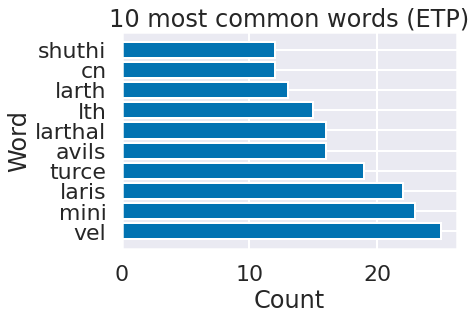

vel : 25
mini : 23
laris : 22
turce : 19
avils : 16
larthal : 16
lth : 15
larth : 13
cn : 12
shuthi : 12


In [15]:
y, w = list(zip(*etp_voc.counts.most_common(10)))
plt.barh(y, w)
plt.title("10 most common words (ETP)")
plt.ylabel("Word")
plt.xlabel("Count")
plt.show()

for i, j in zip(y, w):
    print(i, ":", j)

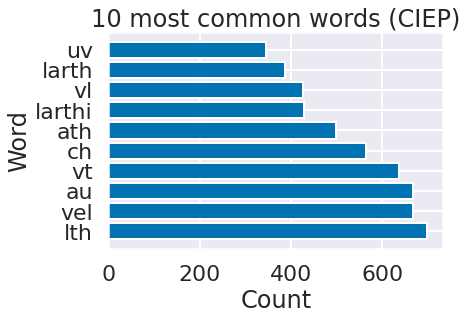

lth : 699
vel : 667
au : 667
vt : 636
ch : 565
ath : 499
larthi : 429
vl : 427
larth : 386
uv : 346


In [16]:
y, w = list(zip(*ciep_voc.counts.most_common(10)))
plt.barh(y, w)
plt.title("10 most common words (CIEP)")
plt.ylabel("Word")
plt.xlabel("Count")
plt.show()

for i, j in zip(y, w):
    print(i, ":", j)

In [17]:
print("Avg. token count in ETP: {:.4f} (SD: {:.4f})".format(np.mean(list(etp_voc.counts.values())), np.std(list(etp_voc.counts.values()))))
print("Avg. token count in CIEP: {:.4f} (SD: {:.4f})".format(np.mean(list(ciep_voc.counts.values())), np.std(list(ciep_voc.counts.values()))))

Avg. token count in ETP: 1.7319 (SD: 2.0320)
Avg. token count in CIEP: 3.7216 (SD: 17.3579)


In [18]:
# from collections import Counter
# tmp = {}
# for i,j in ciep_voc.counts.items():
#     if len(i) > 1:
#         tmp[i] = j
# tmp = Counter(tmp)


# y, w = list(zip(*tmp.most_common(10)))
# plt.barh(y, w)
# plt.title("10 most common words (CIEP)")
# plt.ylabel("Word")
# plt.xlabel("Count")
# plt.show()

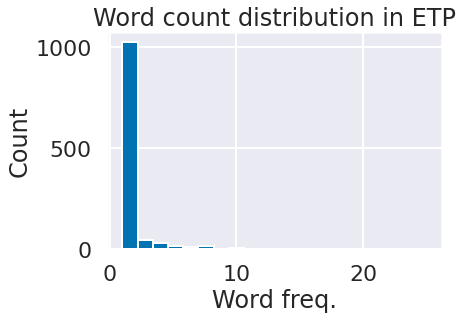

In [19]:
plt.hist(etp_voc.counts.values(), bins=20)
plt.title("Word count distribution in ETP")
plt.ylabel("Count")
plt.xlabel("Word freq.")
# plt.xscale("log")
plt.show()


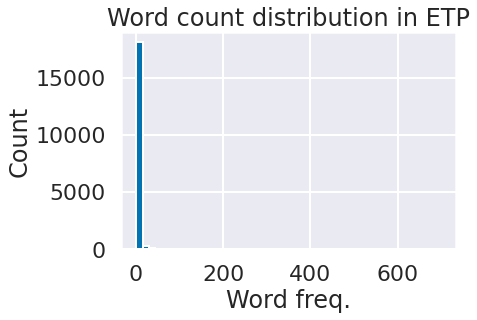

In [20]:
plt.hist(ciep_voc.counts.values(), bins=50)
plt.title("Word count distribution in ETP")
plt.ylabel("Count")
plt.xlabel("Word freq.")
# plt.xscale("log")
plt.show()

ETP has 1161 unique tokes. These include proper names and their declinations.
CIEP has 18747, but some are not correctly extracted from the pdf or contains annotation about missing characters or possible reconstructions.

The tokens has in general a low frequency.

If we look at the most common tokens in ETP we have several proper names (larth, larthal, laris),  demonstrative (cn: "this/that/...") and pronouns (mini: "I/me").

Some appears also in CIEP, but tokens like "lth" and "ath" seem more like part of other tokens.

## Length of tokens

Count the length of the tokens.

In [21]:
from collections import defaultdict

In [22]:
def get_tok_len(voc):
    d = defaultdict(int)    
    for i in voc.counts.keys():
        d[len(i)] += 1
    return d

In [23]:
def mean_from_freq_dict(d):
    tot = 0
    n = 0
    for i, j in d.items():
        tot += i * j
        n += j
    return tot / max(n, 1)

def sd_from_freq_dict(d, mean):
    tot = 0
    n = 0
    for i, j in d.items():
        tot += (i - mean)**2 * j
        n += j        
    return np.sqrt(tot / max(n, 1))


In [24]:
etp_tok_len = get_tok_len(etp_voc)
ciep_tok_len = get_tok_len(ciep_voc)

In [25]:
etp_mean_tok_len = mean_from_freq_dict(etp_tok_len)
etp_sd_tok_len = sd_from_freq_dict(etp_tok_len, etp_mean_tok_len)
ciep_mean_tok_len = mean_from_freq_dict(ciep_tok_len)
ciep_sd_tok_len = sd_from_freq_dict(ciep_tok_len, ciep_mean_tok_len)

print("ETP mean token's length (not counting repetitions): {:.4f} (SD: {:.4f})".format(etp_mean_tok_len, etp_sd_tok_len))
print("CIEP mean token's length (not counting repetitions): {:.4f} (SD: {:.4f})".format(ciep_mean_tok_len, ciep_sd_tok_len))

ETP mean token's length (not counting repetitions): 6.3422 (SD: 2.2658)
CIEP mean token's length (not counting repetitions): 6.6832 (SD: 3.3356)


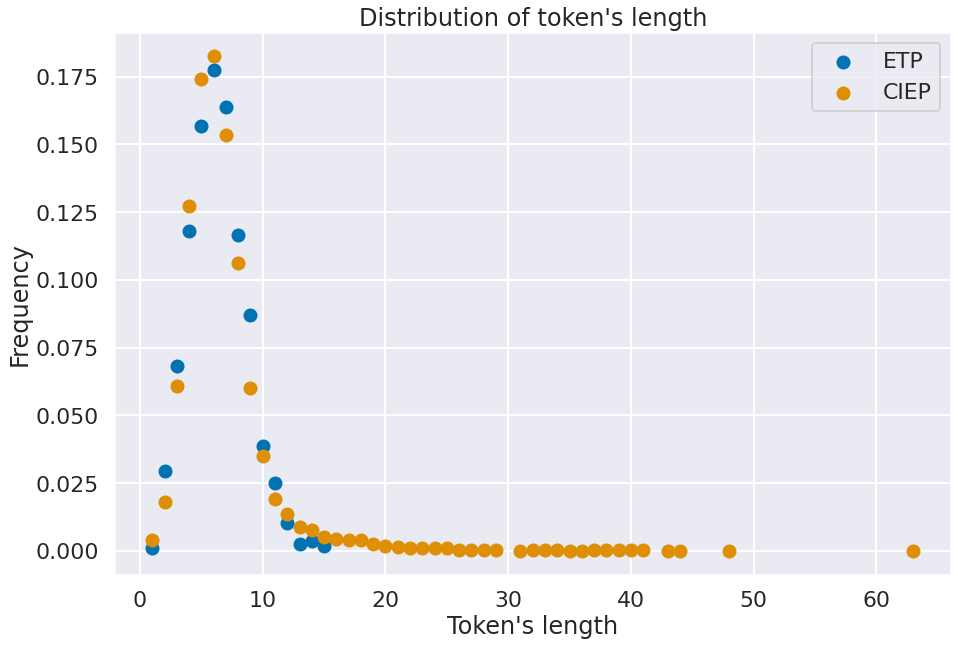

In [26]:
plt.figure(figsize=(15,10))
x = np.array(list(etp_tok_len.keys()))
y = np.array(list(etp_tok_len.values()))
y = y / y.sum()
plt.scatter(x, y, label="ETP")
x = np.array(list(ciep_tok_len.keys()))
y = np.array(list(ciep_tok_len.values()))
y = y / y.sum()
plt.scatter(x, y, label="CIEP")
plt.legend()
plt.title("Distribution of token's length")
plt.ylabel("Frequency")
plt.xlabel("Token's length")
plt.show()

In [27]:
print("Long tokens (>30):")
print("\n".join([i for i in ciep_voc if len(i) > 30]))
# minimuluvanicemamarceapuniievenala -> there are missing white spaces

Long tokens (>30):
rechuvazelesulzirulethesuvapurti
sssssasuseririrarureriraruresisasuse
amlisipithiplrenaietheeraisieepanavnin
amlisiaithipurenaietheeraisteepanamin
minikaisiethannursiannatmulvanic
miaranthramuthasivestiricinalamuluvanice
ethavaithizusuzailimunaatiuthnath
arnunaturaniriasekaseletakalemth
zinacearantharytzinamlachumlacasi
arnkupfkmecestsastlatasemvarkva
rsinistrorsvmasinistrorsvmsdextrorsvm
mimuluarathialethanachvilusprasanaia
pevasnichesiupikutiutisachvilipiperisnati
taniniutikuremiesfiratasuvakfikvepisanes
ivvλteenoslλsesivvλtenevelvλervemλrmλsin
cvrrereinpleoresnevelvervemλrmλr
incvrrereinpleorisnevelvervemλrmλr
vnisλlterneiλdvocλpconctossemvnisλlterneiλdvocλpitconctossimvni
osenosmλrmorivvλtoenosmλrmorivvλtoeno
ivvλtotrivmpetrivmpetrivmpetrivm
minimuluvanicemamarceapuniievenala
vaclarathacileuceticepencathinum
fefmasuveitesalevarvaravapeisnislarekasia
fefmasuveitesalevarvaravapeisnislarekasialseemal
tesalevarvaravapeisnislarekasialseemal
fefmasuveitesalevarvara

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


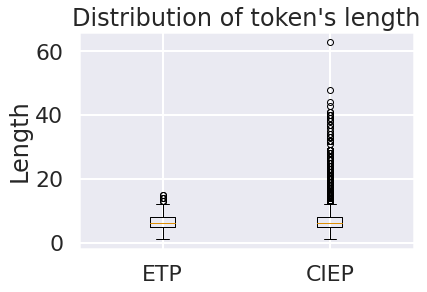

In [28]:
def tok_len(voc):
    l = []
    for i in voc.counts.keys():
        l.append(len(i))
    return l
plt.title("Distribution of token's length")
plt.boxplot([tok_len(etp_voc), tok_len(ciep_voc)])
plt.ylabel("Length")
plt.xticks([1,2], ["ETP", "CIEP"])
plt.show()

The distribution of the length of the tokens is similar for ETP and CIEP in the range \[1, 15\] characters. 
Longer tokens in CIEP are because the white space is not detected.

For example: *minimuluvanicemamarceapuniievenala*.
"mini" should be a token, and the remaining part should be areound three tokens ("mulu...", "mamarc...", "...venala").

## Inscriptions' length

Count how many characters and tokens for each inscriptions.

In [29]:
def count_tok(x: str) -> int:
    return len(wt.tokenize(x))

def count_unique_tok(x: str) -> int:
    return len(set(wt.tokenize(x)))

def count_char(x: str) -> int:
    return len(x)

In [30]:
etp_count_tok = etp["Etruscan"].apply(count_tok)
etp_count_unique_tok = etp["Etruscan"].apply(count_unique_tok)
etp_count_char = etp["Etruscan"].apply(count_char)

ciep_count_tok = ciep_concat["T"].dropna()[ciep_T_no_english].apply(count_tok)
ciep_count_unique_tok = ciep_concat["T"].dropna()[ciep_T_no_english].apply(count_unique_tok)
ciep_count_char = ciep_concat["T"].dropna()[ciep_T_no_english].apply(count_char)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


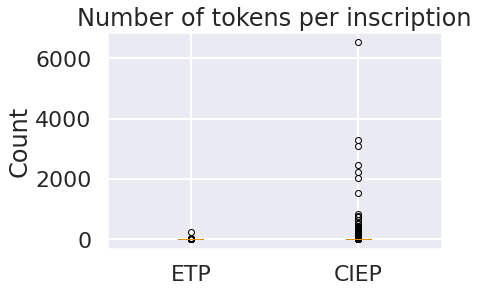

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


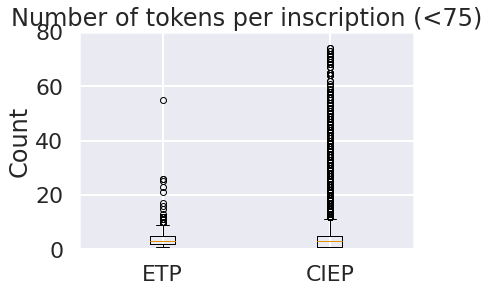

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


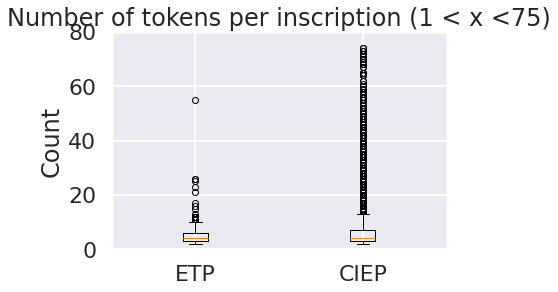

In [31]:
plt.boxplot([etp_count_tok, ciep_count_tok])
plt.title("Number of tokens per inscription")
plt.xticks([1, 2], labels=["ETP", "CIEP"])
plt.ylabel("Count")
plt.show()

plt.boxplot([etp_count_tok[etp_count_tok < 75], ciep_count_tok[ciep_count_tok < 75]])
plt.title("Number of tokens per inscription (<75)")
plt.xticks([1, 2], labels=["ETP", "CIEP"])
plt.ylabel("Count")
plt.ylim([0, 80])
plt.show()

plt.boxplot([etp_count_tok[(1 < etp_count_tok) &  (etp_count_tok < 75)], ciep_count_tok[(1 < ciep_count_tok) & (ciep_count_tok < 75)]])
plt.title("Number of tokens per inscription (1 < x <75)")
plt.xticks([1, 2], labels=["ETP", "CIEP"])
plt.ylabel("Count")
plt.ylim([0, 80])
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


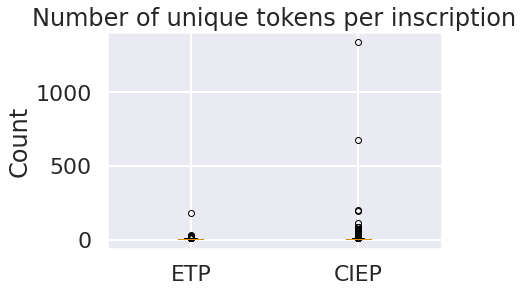

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


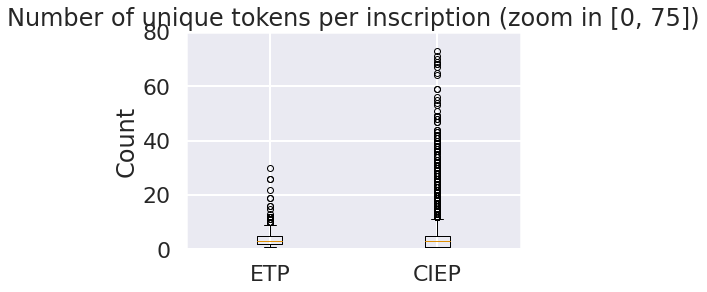

In [32]:
plt.boxplot([etp_count_unique_tok, ciep_count_unique_tok])
plt.title("Number of unique tokens per inscription")
plt.xticks([1, 2], labels=["ETP", "CIEP"])
plt.ylabel("Count")
plt.show()

plt.boxplot([etp_count_unique_tok, ciep_count_unique_tok])
plt.title("Number of unique tokens per inscription (zoom in [0, 75])")
plt.xticks([1, 2], labels=["ETP", "CIEP"])
plt.ylabel("Count")
plt.ylim([0, 80])
plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


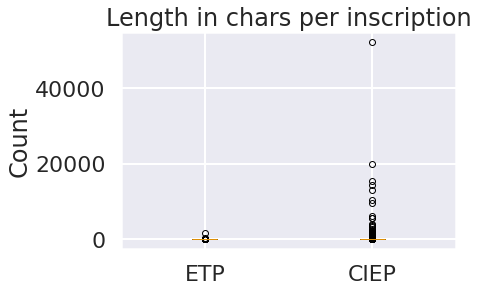

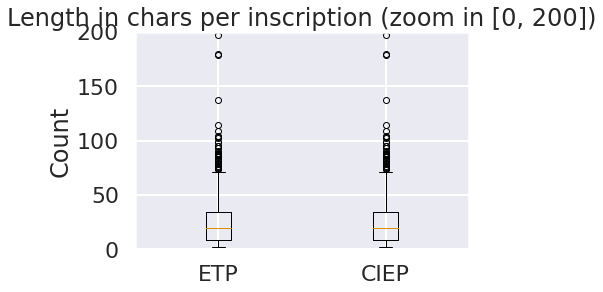

In [33]:
plt.boxplot([etp_count_char, ciep_count_char])
plt.title("Length in chars per inscription")
plt.xticks([1, 2], labels=["ETP", "CIEP"])
plt.ylabel("Count")
plt.show()

plt.boxplot([etp_count_char, etp_count_char])
plt.title("Length in chars per inscription (zoom in [0, 200])")
plt.xticks([1, 2], labels=["ETP", "CIEP"])
plt.ylabel("Count")
plt.ylim([0, 200])
plt.show()

In [34]:
print("ETP, avg. length in tokens: {:.4f} (SD: {:.4f})".format(np.mean(etp_count_tok), np.std(etp_count_tok)))
print("CIEP, avg. length in tokens: {:.4f} (SD: {:.4f})".format(np.mean(ciep_count_tok), np.std(ciep_count_tok)))
print("ETP, avg. length in chars: {:.4f} (SD: {:.4f})".format(np.mean(etp_count_char), np.std(etp_count_char)))
print("CIEP, avg. length in charss: {:.4f} (SD: {:.4f})".format(np.mean(ciep_count_char), np.std(ciep_count_char)))

ETP, avg. length in tokens: 4.4688 (SD: 10.7086)
CIEP, avg. length in tokens: 9.2129 (SD: 92.3764)
ETP, avg. length in chars: 30.1016 (SD: 74.1909)
CIEP, avg. length in charss: 50.1724 (SD: 643.5024)


In [35]:
print(((ciep_count_tok < 75) & (ciep_count_tok > 1)).sum())
print(((ciep_count_tok < 75) & (ciep_count_tok > 2)).sum())
print(((ciep_count_tok < 75) & (ciep_count_tok > 3)).sum())


7188
5814
4446


CIEP has longer inscriptions than EPT. The longest one should the tabula cortonensis, but the others should be investigated.

CIEP also contains many inscriptions with only one token. 
At this point, the CIEP inscriptions with 1 to 75 are around 7200.
5800 are 2 to 75 and 4500 are 3 to 75 tokens.